In [45]:
import sys
sys.path.append("./../../src")
from visualizer_helper import Visualizer

import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn import preprocessing
from scipy.sparse import csr_matrix
import scipy
import pickle
import os
from annoy import AnnoyIndex
from scipy.sparse.linalg import inv
from collections import Counter

In [46]:
k_neighbors = 50
evecs=50

In [47]:
A = pickle.load(open("./data/A_mknn_K{}_CSR.p".format(k_neighbors), "rb"))

D = pickle.load(open("./data/D_mknn_K{}_CSR.p".format(k_neighbors), "rb"))
D_mc = pickle.load(open("./data/D_mc_mknn_K{}_CSR.p".format(k_neighbors), "rb"))

# D_inv_sqrt = pickle.load(open("./data/D_mknn_inv_sqrt_K{}_CSR.p".format(k_neighbors), "rb"))
# D_mc_inv_sqrt = pickle.load(open("./data/D_mc_mknn_inv_sqrt_K{}_CSR.p".format(k_neighbors), "rb"))

L = pickle.load(open("./data/L_mknn_K{}_CSR.p".format(k_neighbors), "rb"))
L_mc = pickle.load(open("./data/L_mc_mknn_K{}_CSR.p".format(k_neighbors), "rb"))

L_evals = pickle.load(open("./data/L_evals{}_K{}.p".format(evecs, k_neighbors), "rb"))
L_evecs = pickle.load(open("./data/L_evecs{}_K{}.p".format(evecs, k_neighbors), 'rb'))

L_mc_evals = pickle.load(open("./data/L_mc_evals{}_K{}.p".format(evecs, k_neighbors), "rb"))
L_mc_evecs = pickle.load(open("./data/L_mc_evecs{}_K{}.p".format(evecs, k_neighbors), "rb"))

print(L_evals.shape, L_evecs.shape)
print(L_mc_evals.shape, L_mc_evecs.shape)

(50,) (42517, 50)
(50,) (42517, 50)


In [48]:
print(np.min(L_evals), np.max(L_evals))
print(np.min(L_mc_evals), np.max(L_mc_evals))
print(np.min(L_evecs), np.max(L_evecs))
print(np.min(L_mc_evecs), np.max(L_mc_evecs))

0.9891483725973962 0.9987488964168921
0.6550622793429456 0.9334493909036834
-0.22400328403588388 0.2549994583395402
-0.12997922265876224 0.2733428367167165


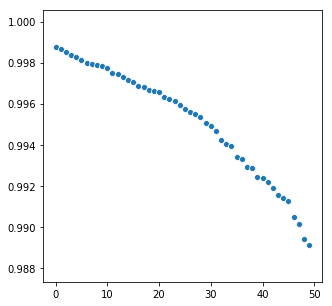

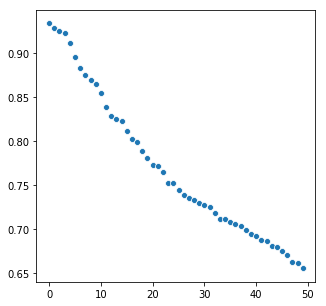

In [49]:
#print(np.flip(L_evals_svd))
plt.figure(figsize=(5,5))
ax = sns.scatterplot(range(L_evals.shape[0]), L_evals)

#print(np.flip(L_mc_evals_svd))
plt.figure(figsize=(5,5))
ax = sns.scatterplot(range(L_mc_evals.shape[0]), L_mc_evals)

In [50]:
def get_evec_df(evecs, top_k_evecs=5):
    k_evecs = evecs[:, -top_k_evecs:]
    evec_cols = ["Evec_{}".format(i) for i in range(top_k_evecs)]
    evec_df = pd.DataFrame(k_evecs, columns=evec_cols)
    return evec_df

describe_topk = 10
L_evecdf = get_evec_df(L_evecs, top_k_evecs=describe_topk)
L_mc_evecdf = get_evec_df(L_mc_evecs, top_k_evecs=describe_topk)

In [51]:
print(L_evecdf.describe())
print(L_mc_evecdf.describe())

             Evec_0        Evec_1        Evec_2        Evec_3        Evec_4  \
count  42517.000000  42517.000000  42517.000000  42517.000000  42517.000000   
mean       0.000562      0.000454     -0.000113      0.000247      0.000376   
std        0.004817      0.004829      0.004848      0.004843      0.004835   
min       -0.135546     -0.168677     -0.158560     -0.145590     -0.150573   
25%        0.000146     -0.000177     -0.000413     -0.000580     -0.000159   
50%        0.000381      0.000457     -0.000105      0.000223      0.000379   
75%        0.000906      0.001191      0.000214      0.001176      0.000788   
max        0.139190      0.176983      0.160468      0.185128      0.212436   

             Evec_5        Evec_6        Evec_7        Evec_8        Evec_9  
count  42517.000000  42517.000000  42517.000000  42517.000000  42517.000000  
mean       0.000479      0.000208      0.000050      0.000033     -0.000014  
std        0.004826      0.004845      0.004850      0

In [52]:
def get_Y(evecs, drop_k_evecs = 1, keep_top_k_evecs = 5):
    X_top_k = evecs[:, -drop_k_evecs-keep_top_k_evecs:-drop_k_evecs]
    evecs_lengths_top_k = np.linalg.norm(X_top_k, axis=1)
    Y_top_k = X_top_k / evecs_lengths_top_k[:, None]
    return Y_top_k[~np.isnan(Y_top_k).any(axis=1)]
    #return Y_top_k

keep_k_evecs=10
drop_k_evecs=2
Y = get_Y(L_evecs, drop_k_evecs=drop_k_evecs, keep_top_k_evecs=keep_k_evecs)
Y_mc = get_Y(L_mc_evecs, drop_k_evecs=drop_k_evecs, keep_top_k_evecs=keep_k_evecs)

print(Y.shape, Y_mc.shape)

(42517, 10) (42517, 10)


In [53]:
print(np.min(Y), np.max(Y))
print(np.min(Y_mc), np.max(Y_mc))

-0.9130608709915784 0.9732643804161164
-0.9928979865774128 0.9894939457397348


In [56]:
visualizer = Visualizer()
lc=100

try:
    Y_umap_2d = pickle.load(open("./data/Y_umap_2d_K{}_topkevecs{}_drop{}_lc{}.p".format(k_neighbors, keep_k_evecs, drop_k_evecs, lc), 'rb'))
    Y_umap_3d = pickle.load(open("./data/Y_umap_3d_K{}_topkevecs{}_drop{}_lc{}.p".format(k_neighbors, keep_k_evecs, drop_k_evecs, lc), 'rb'))

    Y_mc_umap_2d = pickle.load(open("./data/Y_umap_2d_mc_K{}_topkevecs{}_drop{}_lc{}.p".format(k_neighbors, keep_k_evecs, drop_k_evecs, lc), 'rb'))
    Y_mc_umap_3d = pickle.load(open("./data/Y_umap_3d_mc_K{}_topkevecs{}_drop{}_lc{}.p".format(k_neighbors, keep_k_evecs, drop_k_evecs, lc), 'rb'))
except FileNotFoundError:
    print("Error: 1 or more umap files not found")
    Y_umap_2d = visualizer.umap_embedding(Y, n_components=2, lc=lc)
    Y_umap_3d = visualizer.umap_embedding(Y, n_components=3, lc=lc)
    
    Y_mc_umap_2d = visualizer.umap_embedding(Y_mc, n_components=2, lc=lc)
    Y_mc_umap_3d = visualizer.umap_embedding(Y_mc, n_components=3, lc=lc)

    pickle.dump(Y_umap_2d, open("./data/Y_umap_2d_K{}_topkevecs{}_drop{}_lc{}.p".format(k_neighbors, keep_k_evecs, drop_k_evecs, lc), 'wb'))
    pickle.dump(Y_umap_3d, open("./data/Y_umap_3d_K{}_topkevecs{}_drop{}_lc{}.p".format(k_neighbors, keep_k_evecs, drop_k_evecs, lc), 'wb'))

    pickle.dump(Y_mc_umap_2d, open("./data/Y_umap_2d_mc_K{}_topkevecs{}_drop{}_lc{}.p".format(k_neighbors, keep_k_evecs, drop_k_evecs, lc), 'wb'))
    pickle.dump(Y_mc_umap_3d, open("./data/Y_umap_3d_mc_K{}_topkevecs{}_drop{}_lc{}.p".format(k_neighbors, keep_k_evecs, drop_k_evecs, lc), 'wb'))

Error: 1 or more umap files not found


./../../src/visualizer_helper.py:22: UserWarning: Parameter should_downcast is deprecated, use convert_dtype in fit, fit_transform and transform  methods instead. 
  return UMAP(n_components=n_components, local_connectivity=lc).fit_transform(X)


running Kmeans
Cluster labels: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95
 96 97 98 99]


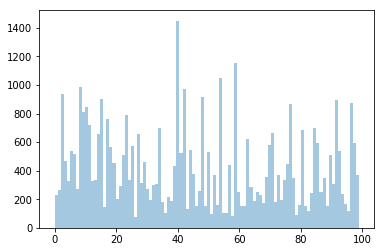

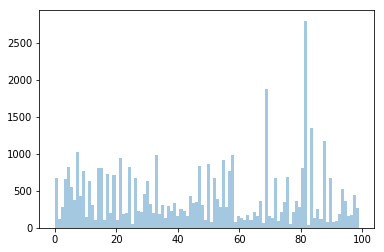

In [57]:
knn_clusters = 100

try:
    Y_cluster_labels = pickle.load(open("./data/cluster_labels_K{}_knn{}_topkevecs{}_drop{}.p".format(k_neighbors, knn_clusters, keep_k_evecs, drop_k_evecs), 'rb'))
    Y_mc_cluster_labels = pickle.load(open("./data/cluster_labels_mc_K{}_knn{}_topkevecs{}_drop{}.p".format(k_neighbors, knn_clusters, keep_k_evecs, drop_k_evecs), 'rb'))

except FileNotFoundError:
    print("running Kmeans")
    
    Y_kmeans = KMeans(n_clusters=knn_clusters).fit(Y)
    Y_mc_kmeans = KMeans(n_clusters=knn_clusters).fit(Y_mc)

    Y_cluster_labels = Y_kmeans.labels_    
    Y_mc_cluster_labels = Y_mc_kmeans.labels_

    pickle.dump(Y_cluster_labels, open("./data/cluster_labels_K{}_knn{}_topkevecs{}_drop{}.p".format(k_neighbors, knn_clusters, keep_k_evecs, drop_k_evecs), "wb"))
    pickle.dump(Y_mc_cluster_labels, open("./data/cluster_labels_mc_K{}_knn{}_topkevecs{}_drop{}.p".format(k_neighbors, knn_clusters, keep_k_evecs, drop_k_evecs), "wb"))

    print("Cluster labels:", np.unique(Y_cluster_labels))
    
print(Y_cluster_labels.shape, Y_mc_cluster_labels.shape)
plt.figure()
sns.distplot(Y_cluster_labels, bins=knn_clusters, kde=False)
plt.figure()
sns.distplot(Y_mc_cluster_labels, bins=knn_clusters, kde=False)

In [58]:
### Save cluster assignments
cluster_assignment_df = pd.read_csv("./data/REMAINING_SUBJECT_IDS.csv")

print(cluster_assignment_df.shape)
print(Y_cluster_labels.shape)

cluster_assignment_df["CLUSTER"] = Y_cluster_labels
cluster_assignment_df["MC_CLUSTER"] = Y_mc_cluster_labels

print(cluster_assignment_df)
cluster_assignment_df.to_csv("./data/CLUSTER_ASSIGNMENTS.csv", index=None)

(42517, 2)
(42517,)
       SUBJECT_ID  ORIGINAL_INDEX  CLUSTER  MC_CLUSTER
0             109               0       91          26
1             112               1       42          58
2             113               2       93          22
3             114               3       29          12
4             115               4        4          82
5             117               6       42           4
6             119               8       59           0
7             122              10       87          70
8             123              11        8          76
9             124              12       85          50
10            125              13       92          45
11            126              14       88          52
12            127              15       50          44
13            128              16       46          73
14            129              17        9          88
15            130              18        5          75
16            131              19       47   

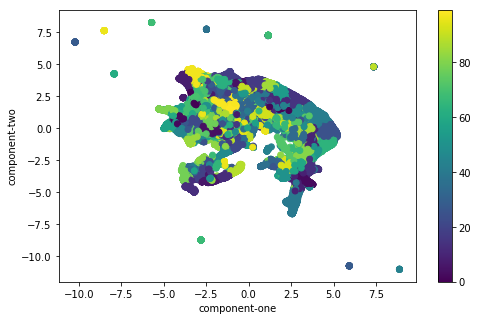

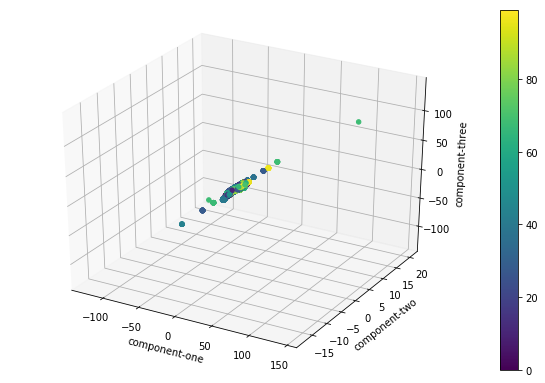

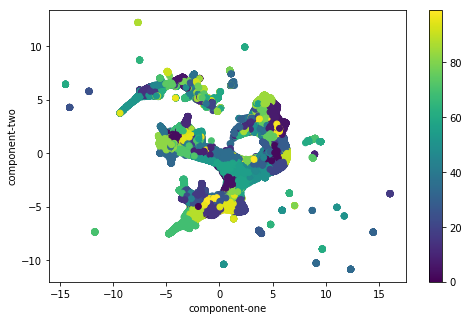

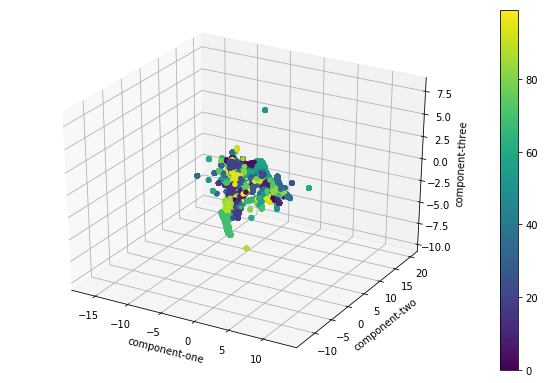

In [63]:
alpha = 1

filename_2d = "./figures/umap2d_K{}_topkevecs{}_knn{}".format(k_neighbors, keep_k_evecs, knn_clusters)
filename_3d = "./figures/umap3d_K{}_topkevecs{}_knn{}".format(k_neighbors, keep_k_evecs, knn_clusters)   

filename_mc_2d = "./figures/umap2d_mc_K{}_topkevecs{}_knn{}".format(k_neighbors, keep_k_evecs, knn_clusters)
filename_mc_3d = "./figures/umap3d_mc_K{}_topkevecs{}_knn{}".format(k_neighbors, keep_k_evecs, knn_clusters)

visualizer.plot2d(
    X=Y_umap_2d, 
    filename=filename_2d, 
    colors=Y_cluster_labels,
    alpha = alpha
)

visualizer.plot3d(
    X=Y_umap_3d, 
    filename=filename_3d, 
    colors=Y_cluster_labels,
    alpha = alpha
)

visualizer.plot2d(
    X=Y_mc_umap_2d, 
    filename=filename_mc_2d, 
    colors=Y_mc_cluster_labels,
    alpha = alpha
)
visualizer.plot3d(
    X=Y_mc_umap_3d, 
    filename=filename_mc_3d, 
    colors=Y_mc_cluster_labels,
    alpha = alpha
)

#PLOT CENTROIDS FOR K MEANS
#PLOT SOME MEMBERS FROM EACH CENTROID


# Cluster Centroids

In [64]:
def compute_centroids(y, cluster_labels):
    centroids = []
    cluster_memberships = {}
    for idx, c in enumerate(cluster_labels):
        if c not in cluster_memberships:
            cluster_memberships[c] = [idx]
        else:
            cluster_memberships[c].append(idx)
    
    unique_labels = np.unique(cluster_labels)
    for c in tqdm(unique_labels):
        cluster_c_idx = cluster_memberships[c]
        cluster_c_embeddings = y[cluster_c_idx]
        if len(cluster_c_embeddings > 0):
            centroids.append(np.mean(cluster_c_embeddings, axis=0))
    return np.array(centroids)

Y_c_umap_2d = compute_centroids(Y_umap_2d, Y_cluster_labels)
Y_c_umap_3d = compute_centroids(Y_umap_3d, Y_cluster_labels)
Y_mc_c_umap_2d = compute_centroids(Y_mc_umap_2d, Y_mc_cluster_labels)
Y_mc_c_umap_3d = compute_centroids(Y_mc_umap_3d, Y_mc_cluster_labels)

100%|██████████| 100/100 [00:00<00:00, 11217.42it/s]


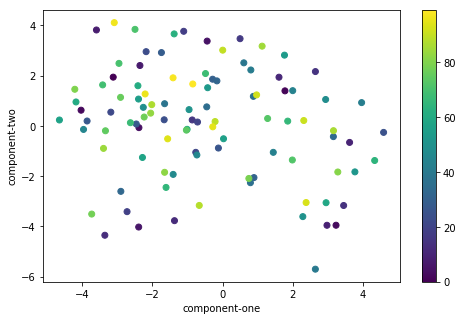

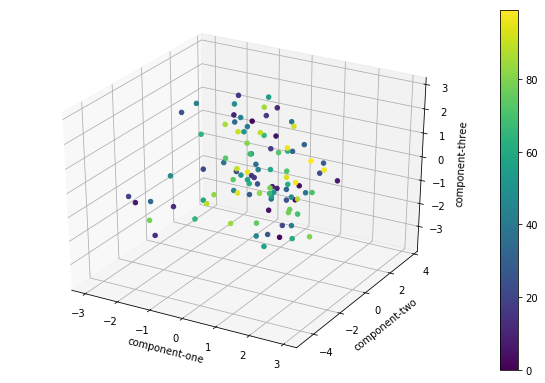

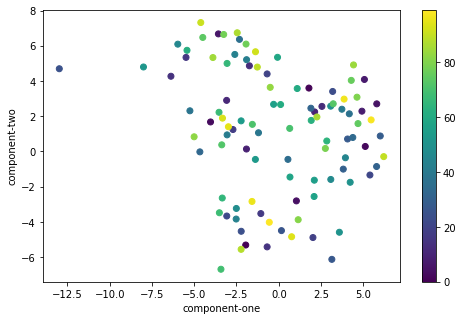

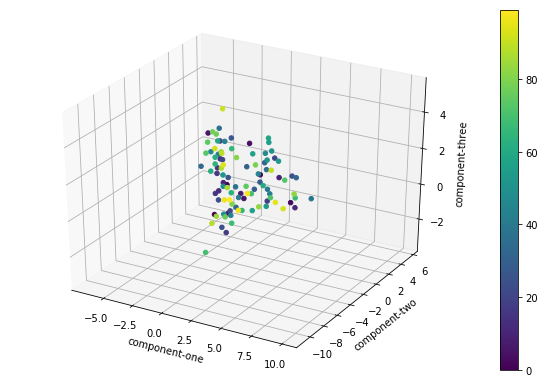

In [65]:
alpha = 1

filename_2d = "./figures/centroids2d_K{}_topkevecs{}_knn{}".format(k_neighbors, keep_k_evecs, knn_clusters)
filename_3d = "./figures/centroids3d_K{}_topkevecs{}_knn{}".format(k_neighbors, keep_k_evecs, knn_clusters)   

filename_mc_2d = "./figures/centroids2d_mc_K{}_topkevecs{}_knn{}".format(k_neighbors, keep_k_evecs, knn_clusters)
filename_mc_3d = "./figures/centroids3d_mc_K{}_topkevecs{}_knn{}".format(k_neighbors, keep_k_evecs, knn_clusters)

colors = range(knn_clusters)

visualizer.plot2d(
    X=Y_c_umap_2d, 
    filename=filename_2d, 
    colors=colors,
    alpha = alpha
)

visualizer.plot3d(
    X=Y_c_umap_3d, 
    filename=filename_3d, 
    colors=colors,
    alpha = alpha
)

visualizer.plot2d(
    X=Y_mc_c_umap_2d, 
    filename=filename_mc_2d, 
    colors=colors,
    alpha = alpha
)
visualizer.plot3d(
    X=Y_mc_c_umap_3d, 
    filename=filename_mc_3d, 
    colors=colors,
    alpha = alpha
)

100%|██████████| 100/100 [00:00<00:00, 11397.57it/s]


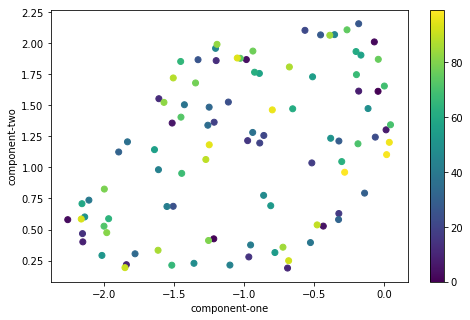

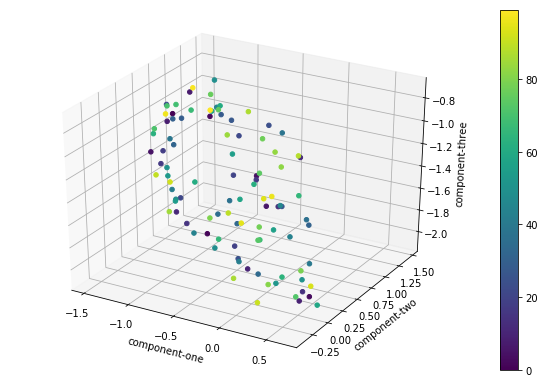

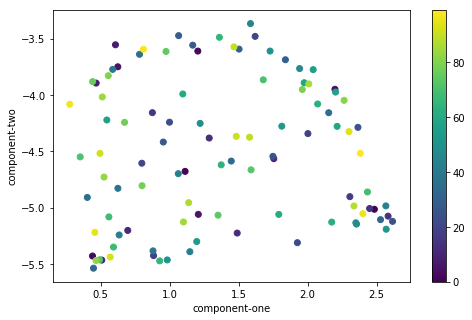

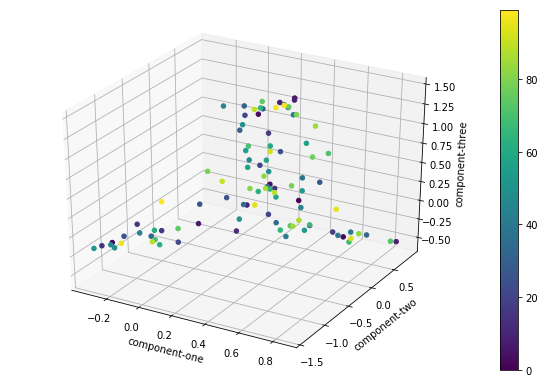

In [66]:
lc=100

Y_centroids = compute_centroids(Y, Y_cluster_labels)
Y_mc_centroids = compute_centroids(Y_mc, Y_mc_cluster_labels)

Y_centroid_umap_2d = visualizer.umap_embedding(Y_centroids, n_components=2, lc=lc)
Y_centroid_umap_3d = visualizer.umap_embedding(Y_centroids, n_components=3, lc=lc)

Y_mc_centroid_umap_2d = visualizer.umap_embedding(Y_mc_centroids, n_components=2, lc=lc)
Y_mc_centroid_umap_3d = visualizer.umap_embedding(Y_mc_centroids, n_components=3, lc=lc)

alpha = 1
colors = range(knn_clusters)
filename="./figures/dummy"

visualizer.plot2d(
    X=Y_centroid_umap_2d, 
    filename=filename, 
    colors=colors,
    alpha = alpha
)

visualizer.plot3d(
    X=Y_centroid_umap_3d, 
    filename=filename, 
    colors=colors,
    alpha = alpha
)

visualizer.plot2d(
    X=Y_mc_centroid_umap_2d, 
    filename=filename, 
    colors=colors,
    alpha = alpha
)
visualizer.plot3d(
    X=Y_mc_centroid_umap_3d, 
    filename=filename, 
    colors=colors,
    alpha = alpha
)

In [67]:
def sort_by_cluster_membership(M, cluster_labels):
    sorted_cluster_labels = sorted(list(enumerate(cluster_labels.tolist())), key=lambda p: p[1])
    clusters_by_idx = [p[0] for p in sorted_cluster_labels]
    return M[clusters_by_idx][:, clusters_by_idx]

def sort_by_top_k_cluster_membership(M, k, cluster_labels, exclude=2):    
    
    top_cluster_and_counts = Counter(cluster_labels).most_common(k + exclude)
    print(top_cluster_and_counts)
    top_cluster_and_counts = top_cluster_and_counts[exclude:]
    print("...".format(exclude), top_cluster_and_counts)
    most_common_clusters = [c[0] for c in top_cluster_and_counts]

    sorted_cluster_labels = sorted(list(enumerate(cluster_labels.tolist())), key=lambda p: p[1])
    
    sorted_cluster_labels_filtered = [p for p in sorted_cluster_labels if p[1] in most_common_clusters]
    clusters_by_idx = [p[0] for p in sorted_cluster_labels_filtered]
    return M[clusters_by_idx][:, clusters_by_idx]
    
L_sorted = sort_by_cluster_membership(L, Y_cluster_labels)
L_mc_sorted = sort_by_cluster_membership(L_mc, Y_mc_cluster_labels)

A_sorted = sort_by_cluster_membership(A, Y_cluster_labels)
A_mc_sorted = sort_by_cluster_membership(A, Y_mc_cluster_labels)

topk_clusters = 3
exclude_topk = 0
A_sorted_topk = sort_by_top_k_cluster_membership(A, topk_clusters, Y_cluster_labels, exclude_topk)
L_sorted_topk = sort_by_top_k_cluster_membership(L, topk_clusters, Y_cluster_labels, exclude_topk)

A_mc_sorted_topk = sort_by_top_k_cluster_membership(A, topk_clusters, Y_mc_cluster_labels, exclude_topk)
L_mc_sorted_topk = sort_by_top_k_cluster_membership(L_mc, topk_clusters, Y_mc_cluster_labels, exclude_topk)

print(L_sorted.shape, A_sorted.shape, L_mc_sorted.shape, A_mc_sorted.shape)
print(L_sorted_topk.shape, A_sorted_topk.shape, L_mc_sorted_topk.shape, A_mc_sorted_topk.shape)

[(40, 1450), (59, 1156), (54, 1048)]
... [(40, 1450), (59, 1156), (54, 1048)]
[(40, 1450), (59, 1156), (54, 1048)]
... [(40, 1450), (59, 1156), (54, 1048)]
[(82, 2803), (69, 1885), (84, 1352)]
... [(82, 2803), (69, 1885), (84, 1352)]
[(82, 2803), (69, 1885), (84, 1352)]
... [(82, 2803), (69, 1885), (84, 1352)]
(42517, 42517) (42517, 42517) (42517, 42517) (42517, 42517)
(3654, 3654) (3654, 3654) (6040, 6040) (6040, 6040)


# Heatmaps

In [ ]:
##Full Heatmaps
plot_vars = [A_sorted_topk, A_mc_sorted_topk, L_sorted_topk, L_mc_sorted_topk]
plot_var_names = ['A_sorted_topk', 'A_mc_sorted_topk', 'L_sorted_topk', 'L_mc_sorted_topk']
for v in range(len(plot_vars)):
    var = plot_vars[v]
    varname = plot_var_names[v]

    plotmax = var.log1p().log1p().max()/2.0
    plt.figure(figsize=(20,16))
    sns.heatmap(var.log1p().log1p().toarray(), cmap="Reds", vmax=plotmax)
    plt.savefig("./figures/heatmap_{}_K{}_knn{}_kevecs{}.png".format(varname, k_neighbors, knn_clusters, keep_k_evecs))